# Toy VQE Experiment using linear optical differentiation

We use the method of differentiating linear optics from https://arxiv.org/abs/2401.07997 to perform a toy **V**ariational **Q**uantum **E**igensolver experiment.

The purpose of VQE is to find the ground state $\ket{\psi(\theta)}$ of an observable $H$.

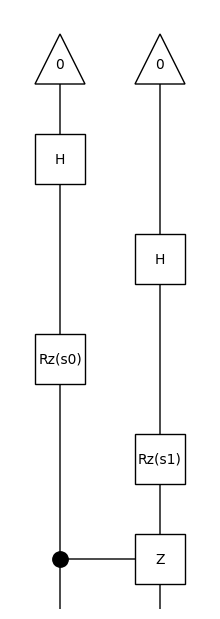

In [1]:
from discopy.quantum.circuit import Id
from discopy.quantum.gates import X, Ket, Bra, H, CRz, Rz
from sympy import Symbol

syms = [Symbol(f's{i}') for i in range(3)]
circ = Ket(0, 0).H(0).H(1).Rz(syms[0], 0).Rz(syms[1], 1).CZ(0, 1)

circ.draw()

Construct $E = \bra{\psi(-\theta)}H\ket{\psi(\theta)}$

$H = \frac{1}{2}[(Z + X)\otimes(Z + X)]$ is an Hermitian matrix.

The ground state is the state which minimises the expression $\bra{\psi(-\theta)}H\ket{\psi(\theta)}\$, known as the expectation of the observable.

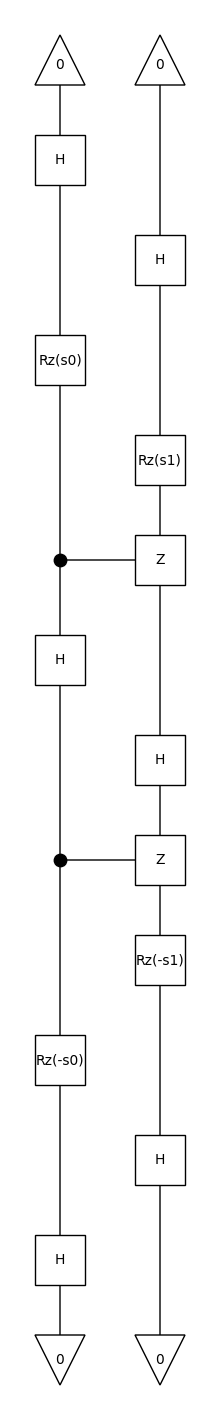

In [2]:
exp = circ >> Id().tensor(*[H] * len(circ.cod)) >> circ.dagger()
exp.draw()

In [3]:
from optyx.qubits import Circuit
from optyx.core.backends import DiscopyBackend

In [7]:
path_exp = Circuit(exp).to_dual_rail()

In [ ]:
def to_float(x):
    if isinstance(x, complex):
        assert x.imag < 1e-10
        return x.real
    return x

free_syms = exp.free_symbols

path_exp = Circuit(exp).to_dual_rail()

f_exp = lambda xs: to_float(path_exp.lambdify(*free_syms)(*xs).eval().tensor.array)
orig_f_exp = lambda xs: to_float(exp.lambdify(*free_syms)(*xs).eval().array.item())

def d_f_exp(xs):
    return [
        path_exp.grad(s).lambdify(*free_syms)(*xs).eval().tensor.array
        for s in free_syms
    ]

We use gradient descent to minimise the expectation.

In [ ]:
from tqdm import tqdm

xs = []
fxs = []
dfxs = []

def optimize(x0):
    x = x0

    for _ in tqdm(range(20)):
        orig_fx = orig_f_exp(x)
        fx = f_exp(x)
        dfx = d_f_exp(x)
        # verifies that the conversion is correct
        assert abs(orig_fx - fx) < 1e-10

        xs.append(x[::])
        fxs.append(fx)
        dfxs.append(dfx)
        for i, dfxx in enumerate(dfx):
            x[i] = to_float(x[i] - 0.01 * dfxx)
    xs.append(x[::])
    fxs.append(f_exp(x))
    dfxs.append(d_f_exp(x))

In [10]:
optimize([0.1, 0.2])

  5%|▌         | 1/20 [00:02<00:41,  2.20s/it]

0.8385254915624215


 10%|█         | 2/20 [00:04<00:38,  2.16s/it]

0.7711039313289111


 15%|█▌        | 3/20 [00:06<00:36,  2.15s/it]

0.6787280203868928


 20%|██        | 4/20 [00:08<00:33,  2.09s/it]

0.561851722253541


 25%|██▌       | 5/20 [00:10<00:31,  2.12s/it]

0.4296238247323758


 30%|███       | 6/20 [00:12<00:29,  2.13s/it]

0.29959341800206996


 35%|███▌      | 7/20 [00:14<00:27,  2.13s/it]

0.18996344005095658


 40%|████      | 8/20 [00:16<00:25,  2.09s/it]

0.10985803661254136


 45%|████▌     | 9/20 [00:19<00:23,  2.11s/it]

0.057103882372305376


 50%|█████     | 10/20 [00:21<00:21,  2.11s/it]

0.023521573022446115


 55%|█████▌    | 11/20 [00:23<00:18,  2.08s/it]

0.000415985082452835


 60%|██████    | 12/20 [00:25<00:16,  2.10s/it]

-0.01932481270375224


 65%|██████▌   | 13/20 [00:27<00:14,  2.11s/it]

-0.04148099296641865


 70%|███████   | 14/20 [00:29<00:12,  2.08s/it]

-0.0714343170674597


 75%|███████▌  | 15/20 [00:31<00:10,  2.10s/it]

-0.11488446907551937


 80%|████████  | 16/20 [00:33<00:08,  2.11s/it]

-0.17779636062909193


 85%|████████▌ | 17/20 [00:35<00:06,  2.11s/it]

-0.2649466539403759


 90%|█████████ | 18/20 [00:37<00:04,  2.09s/it]

-0.3766785210831544


 95%|█████████▌| 19/20 [00:40<00:02,  2.11s/it]

-0.5051429153418859


100%|██████████| 20/20 [00:42<00:00,  2.11s/it]

-0.6340993442622342


<Axes: >

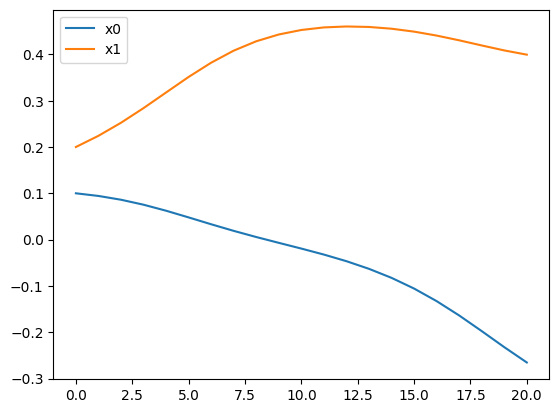

In [11]:
from pandas import DataFrame, Series

DataFrame({
    'Expectation': fxs,
    **{f'x{i}': [v[i] for v in xs] for i in range(len(free_syms))}
}).plot()